In [36]:
### Presentation

# (5 minutes) Introduction to the guys Rumelhart, Hinton, Williams (Focus on Hinton).
# (2-10 mins) Presentation of the paper "Learning representations by back-propagating errors" (1986).
     # How to find optimum
     # Backpropagation
     # Results and experiments
# (5-10 mins) Experiments
     # Presentation of the experiments
# (5-10 mins) Relevant works and applications
     # Buzzword section: 
        # Sigmoid, backpropagation, nesterov, random weights, overparameterization, recurrent
    # Extensions
        

In [37]:
import matplotlib.pyplot as plt
from typing import List, Callable
from dataclasses import dataclass
from numpy.random import randn, rand
from numpy import sin, cos, pi

@dataclass
class DAG:
    func: Callable
    parents: List
    children: List
    value: float = None
    grad: float = None
    pgrads: float = None
    grads_recieved: int = 0


    def has_value(self): return self.value is not None
    
    def has_children(self): return len(self.children) > 0
    
    def has_parents(self):return len(self.parents) > 0
    
    def update(self):
        val, grads = self.func(*[p.value for p in self.parents])
        self.value, self.pgrads = val, grads
        return self
    
    def forward(self):
        for pdag in self.parents:
            if not pdag.has_value():
                pdag.forward()
        return self.update()
    
    def backward(self, perturb=1.0):
        self.grad = perturb if self.grad is None else self.grad + perturb
        self.grads_recieved += 1
        if self.grads_recieved >= len(self.children) and self.has_parents():
            for p, pg in zip(self.parents, self.pgrads):
                p.backward(self.grad * pg)
        return self
    
    
    def full_forward(self, param):
        for pdag in self.parents:
            pdag.full_forward(param)
        if self.has_value():
            self.grad=1.0 if self is param else 0.0
        else:        
            val, grads = self.func(*[p.value for p in self.parents])
            self.value = val
            self.grad = 1.0 if self is param else sum([g * p.grad for g, p in zip(grads, self.parents)])
        return self
def update_children(dag):
    for p in dag.parents:
        p.children.append(dag) if dag not in p.children else None
        update_children(p)
    return dag
    


# Example 1: f(x, p, q, r) = r*(p*x + q/x)
The function can be represented as a directed acyclic graph (DAG):

```
[p] ------                   [r]                          
          \                    \                          
           A:[(p,x) -> p*x]---  \                         
          /                   \  \                        
[x] ------                      ---C:[(A,B,r) -> r*(A+B)] 
          \                   /                           
           B:[(x,q) -> q/x]---                            
          /                                               
[q] ------                                                

```
In node A we need to supply the multiplication function ```f1:(p,x)->x*p``` and its gradient ```df1:(p,x)->(x,p)```

In node B we need to supply the division function ```f2:(x,q) -> q/x``` and its gradient ```df2:(x,q) -> (-q/x^2, 1/x)```

In node C we need to supply the summation function ```f3:(A,B,r) -> r(A+B)``` and its gradient ```df3:(A,B,r) -> (r,r,A+B)```.

In [38]:
def variable(val):
    return DAG(None, [], [], val)


# A simple network that computes 
# f(x, p, q, r) = r * (p * x + q/x)  
# (I envision x as the input and p,q,r as parameters)
def network(x0, p0, q0, r0):
    ## Computation dag
    f1 = lambda d0, p1: (p1*d0, (p1, d0))
    f2 = lambda d0, p2: (p2/d0, (-p2/d0**2, 1./d0))
    f3 = lambda d1, d2, p3: (p3*(d1 + d2), (p3, p3, d1 + d2))

    # Input
    inp0 = variable(x0)
    
    # Parameters
    par1 = variable(p0)
    par2 = variable(q0)
    par3 = variable(r0)

    # Network
    dag1 = DAG(f1, [inp0, par1], [])
    dag2 = DAG(f2, [inp0, par2], [])
    dag3 = DAG(f3, [dag1, dag2, par3], [])
    
    update_children(dag3)
    return dag3, inp0, (par1, par2, par3)


# Alternative 1: Forward propagation then backward propagation
model, x, params = network(2.0, 1.0, 4.0, 1.0)
model.forward()  
model.backward() 
print(f"Reverse mode.")
print(f"Nodal values. output:{model.value:.2f}, p:{params[0].value:.2f}, q:{params[1].value:.2f}, r:{params[2].value:.2f}")
print(f"Nodal gradients. output:{model.grad:.2f}, p:{params[0].grad:.2f}, q:{params[1].grad:.2f}, r:{params[2].grad:.2f}")

# Alternative 2: Full forward propagation
model, x, params = network(2.0, 1.0, 4.0, 1.0)
model.full_forward(params[0])
print("=====")
print(f"Forward mode.")
print(f"Nodal values. output:{model.value:.2f}, p:{params[0].value:.2f}, q:{params[1].value:.2f}, r:{params[2].value:.2f}")
print(f"Nodal values. output:{model.grad:.2f}, p:{params[0].grad:.2f}, q:{params[1].grad:.2f}, r:{params[2].grad:.2f}")

# Explanation
print("=====")
print("Explanation.\nIn reverse mode, the value of the output node is its derivative wrt. itself (=1).")
print("The values of p,q,r are the derivatives of the output wrt. p,q,r.")
print("In forward mode, the value of the output node is the derivative of itself wrt. p.")
print("The value of p is the derivative of the output wrt. p (=1),")
print("The values of q,r are independent of p so their derivatives wrt. p are 0.")

Reverse mode.
Nodal values. output:4.00, p:1.00, q:4.00, r:1.00
Nodal gradients. output:1.00, p:2.00, q:0.50, r:4.00
=====
Forward mode.
Nodal values. output:4.00, p:1.00, q:4.00, r:1.00
Nodal values. output:2.00, p:1.00, q:0.00, r:0.00
=====
Explanation.
In reverse mode, the value of the output node is its derivative wrt. itself (=1).
The values of p,q,r are the derivatives of the output wrt. p,q,r.
In forward mode, the value of the output node is the derivative of itself wrt. p.
The value of p is the derivative of the output wrt. p (=1),
The values of q,r are independent of p so their derivatives wrt. p are 0.


## Larger network (learning sin(x))

In [39]:
def variable(val):
    return DAG(None, [], [], val)

def linear_node(inputs):
    weights = [variable(randn()) for _ in inputs]
    bias = variable(randn())
    
    def f(*args):
        N = len(args)//2
        inputs = args[:N]
        weights = args[N:-1]
        bias = args[-1]
        L = len(weights) # Scaling the output but not the gradient?
        out = sum([i*w for i,w in zip(inputs, weights)])/L + bias
        return out, tuple([w/L for w in weights]) + tuple([i/L for i in inputs]) + (1.0,)
    
    return DAG(f, inputs + weights + [bias], []), (weights, bias)


def activation_node(inputs, activation):
    linear_node_, param = linear_node(inputs)
    return DAG(activation, [linear_node_], []), param
        

def layer(inputs, size, activation):
    params = []
    nodes = []
    for _ in range(size):
        node_, param_ = activation_node(inputs, activation)
        nodes.append(node_)
        params.append(param_)
    return nodes, params

def mlp(inputs, layer_sizes, activation):
    layers = [[inputs]]
    params = []
    # Intemediate layers
    for layer_size in layer_sizes:
        nodes, param = layer(layers[-1], layer_size, activation)
        params.append(param)
        layers.append(nodes)
    # Output layer
    node, param = linear_node(layers[-1])
    params.append(param)
    layers.append([node])
    return node, layers, params

def loss_dag(y1dag, y2dag):
    loss = lambda y1, y2: ((y1 - y2)**2, (2*(y1 - y2), 2*(y2 - y1)))
    dag = DAG(loss, [y1dag, y2dag], [])
    return dag

def network(x_data: float, y_data: float, layer_sizes: List[int], activation: Callable):    
    x_dag = variable(x_data)
    y_dag = variable(y_data)
    mlp_dag_, _, params = mlp(x_dag, layer_sizes, activation)
    loss_dag_ = loss_dag(mlp_dag_, y_dag)
    return loss_dag_, mlp_dag_, params, x_dag, y_dag


def reset_net(dag):
    dag.value = None if dag.has_parents() else dag.value
    dag.grad = None
    for p in dag.parents:
        reset_net(p)
        
def step_params(params, lr):
    if isinstance(params, DAG):
        params.value = params.value - lr * params.grad
    else:
        for p in params:
            step_params(p, lr)

activation = lambda x: (max(0., x), (1. if x > 0 else 0.,))

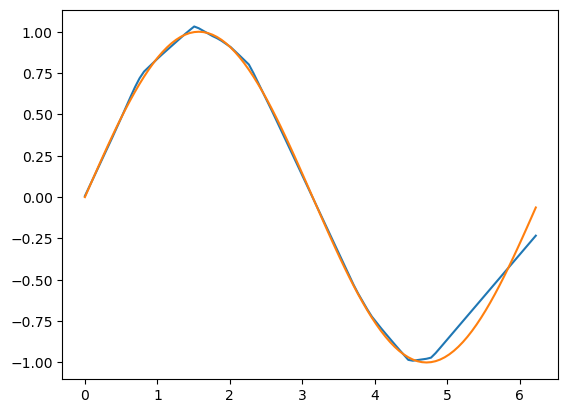

In [40]:
N = 100
x = [2*pi*n/N for n in range(N)]
f = lambda x: sin(x)

loss, mlp, par, xdag, ydag = network(0., 0., [40,40], activation)
update_children(loss) # Add children to the nodes, the network is defined in reverse order

for epoch in range(80000):
    # Sample random data
    xdag.value = rand() * 2 * pi
    ydag.value = f(xdag.value) + rand()*0.01 # Add noise

    # Step with loss 
    loss.forward().backward()
    print(f"Epoch {epoch}, Loss: {loss.value:.2e}", end="\r")
    step_params(par, 0.01)
    reset_net(loss)


# Plot result:
ymlp = []
for xi in x:
    xdag.value = xi
    mlp.forward()
    ymlp.append(mlp.value)
    reset_net(mlp)

plt.plot(x, ymlp)
plt.plot(x, [f(xi) for xi in x])
